In [50]:
###### PDF Extract
from unstructured.partition.pdf import partition_pdf


############## Vector Stores ################
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
import os

############## Summaries ####################
import openai
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.chains import LLMChain
from langchain_openai import ChatOpenAI
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAI


############ RAG PIPELINE ###########
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from base64 import b64decode


######### PODCAST ############
from podcastfy.client import generate_podcast



###### AUDIO DISPLAY ##############
from IPython.display import Audio, display


############ Keys ##########
from dotenv import load_dotenv
load_dotenv()

True

# Stage 1 : Partition PDF

In [16]:
file_path = "data/pdfs/attention.pdf"

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    # image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    # extract_images_in_pdf=True,          # deprecated
)

# Stage 2 : Extracting Text, Tables and Images from : Partition PDF

# Texts

In [17]:
# Get the images from the CompositeElement object
texts=chunks
print(texts[0])

2023

1706.03762v7 [cs.CL] 2 Aug

arXiv

Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.

Attention Is All You Need

Ashish Vaswani* Google Brain avaswani@google.com

Noam Shazeer* Google Brain noam@google.com

Niki Parmar* Google Research nikip@google.com

Jakob Uszkoreit* Google Research usz@google.com

Llion Jones*

Google Research llion@google.com

Aidan N. Gomez* ¢ University of Toronto aidan@cs.toronto.edu

Lukasz Kaiser* Google Brain lukaszkaiser@google.com

Illia Polosukhin* *

illia.polosukhin@gmail.com

Abstract

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dis

# Tables

In [20]:
# Get the images from the CompositeElement objects
def get_tables(chunks):
    tables_dict = {}
    tables_html_dict={}
    count=0
    for chunk in chunks: 
        elements = chunk.metadata.orig_elements
        for el in elements:
            if 'Table' in str(type(el)):
                chunk_tables = [el for el in elements if 'Table' in str(type(el))]
                chunk_tables_html = [el.metadata.text_as_html for el in elements if 'Table' in str(type(el))]
                tables_dict[count] = chunk_tables
                tables_html_dict[count] = chunk_tables_html
        count+=1
            
    return tables_dict, tables_html_dict


tables, tables_html = get_tables(chunks)

In [21]:
tables_html

{5: ['<table><thead><tr><th>Layer Type</th><th>Complexity per Layer</th><th>Sequential Operations</th><th>Maximum Path Length</th></tr></thead><tbody><tr><td>Self-Attention</td><td>O(n? - d)</td><td>O(1)</td><td>O(1)</td></tr><tr><td>Recurrent</td><td>O(n- d?)</td><td>O(n)</td><td>O(n)</td></tr><tr><td>Convolutional</td><td>O(k-n-d?)</td><td>O(1)</td><td>O(logy(n))</td></tr><tr><td>Self-Attention (restricted)</td><td>O(r-n-d)</td><td>ol)</td><td>O(n/r)</td></tr></tbody></table>'],
 7: ['<table><thead><tr><th>Model</th><th>EN-DE</th><th>BLEU EN-FR</th><th>Training EN-DE</th><th>Cost (FLOPs) EN-FR</th></tr></thead><tbody><tr><td colspan="5">ByteNet [18] 23.75</td></tr><tr><td>Deep-Att + PosUnk</td><td></td><td>39.2</td><td></td><td>1.0 - 107°</td></tr><tr><td>GNMT + RL 8]</td><td>24.6</td><td>39.92</td><td>2.3-10!9</td><td>1.4-1070</td></tr><tr><td>ConvS28S [9]</td><td>25.16</td><td>40.46</td><td>9.6-10\'%</td><td>1.5-1070</td></tr><tr><td>MoE</td><td>26.03</td><td>40.56</td><td>2.0-10\'

# Images

In [22]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        chunk_els = chunk.metadata.orig_elements
        for el in chunk_els:
            if "Image" in str(type(el)):
                images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

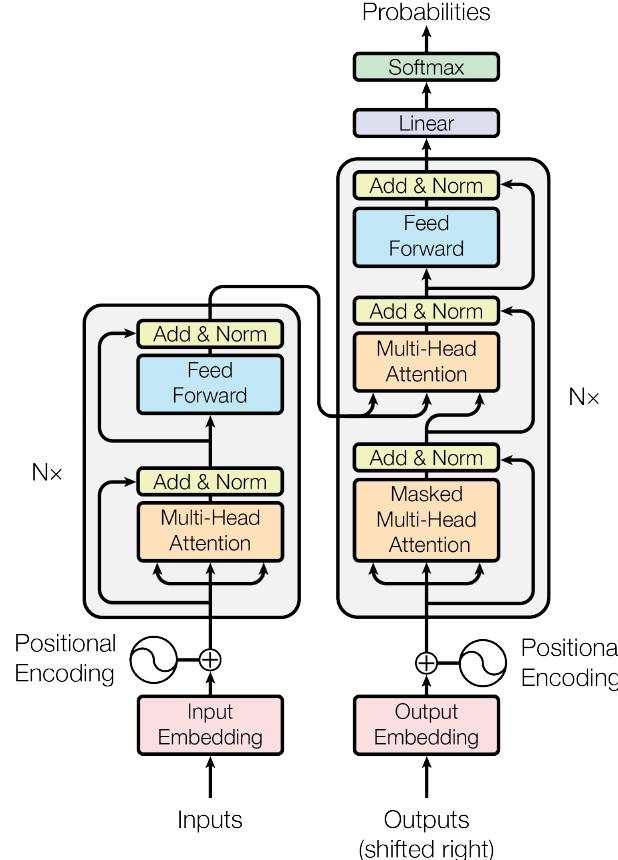

In [25]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[0])

# Stage 3a :Summarizing Tables and Text per Chunk

In [26]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additional comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatOpenAI(model="gpt-4o-mini")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [27]:
text_summaries = summarize_chain.batch(texts, {"max_concurrency" : 3})
table_summaries = summarize_chain.batch(tables_html.values(), {"max_concurrency" : 3})

In [28]:
table_summaries

['The table compares four layer types in machine learning: Self-Attention, Recurrent, Convolutional, and Restricted Self-Attention. Each layer type has varying complexities per layer, sequential operations, and maximum path lengths. Self-Attention has a complexity of O(n? - d) with O(1) sequential operations and O(1) maximum path length. Recurrent layers have a complexity of O(n - d?) with O(n) operations and O(n) path length. Convolutional layers show a complexity of O(k-n-d?), O(1) operations, and O(logy(n)) path length. Restricted Self-Attention has a complexity of O(r-n-d), unspecified operations, and O(n/r) path length.',
 'The table presents various translation models along with their performance metrics: EN-DE scores, BLEU scores for EN-FR, training requirements for EN-DE, and associated costs in FLOPs for EN-FR. Models like ByteNet, GNMT, and Transformer show varying BLEU scores, with GNMT + RL Ensemble achieving the highest BLEU score of 41.16. The Transformer models demonstra

In [29]:
text_summaries

['The paper introduces the Transformer, a new architecture for sequence transduction based solely on attention mechanisms, eliminating the need for recurrent or convolutional neural networks. The Transformer outperforms existing models in machine translation tasks, achieving a BLEU score of 28.4 for English-to-German and 41.8 for English-to-French, significantly reducing training time and costs. The contributions of multiple authors from Google Brain and Google Research are acknowledged, highlighting their roles in developing and implementing the model and its variants. The Transformer also exhibits strong generalization to other tasks, such as English constituency parsing.',
 "The introduction discusses advancements in recurrent neural networks (RNNs) and highlights the challenges of sequential computation in tasks like language modeling and machine translation. It proposes the Transformer model, which relies entirely on attention mechanisms for parallel processing, improving computat

# Stage 3b: Summarizing Images per Chunk

In [30]:


prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the transformers
                  architecture. Be specific about graphs, such as bar plots."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()


image_summaries = chain.batch(images)

In [31]:
chain

ChatPromptTemplate(input_variables=['image'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=[PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='Describe the image in detail. For context,\n                  the image is part of a research paper explaining the transformers\n                  architecture. Be specific about graphs, such as bar plots.'), ImagePromptTemplate(input_variables=['image'], input_types={}, partial_variables={}, template={'url': 'data:image/jpeg;base64,{image}'})], additional_kwargs={})])
| ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x2b531b050>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x2b7c663f0>, root_client=<openai.OpenAI object at 0x2b4746f00>, root_async_client=<openai.AsyncOpenAI object at 0x2b531a090>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'))
| StrOutputParse

In [32]:
print(image_summaries[1])

The image depicts two components of the transformer architecture: "Scaled Dot-Product Attention" on the left and "Multi-Head Attention" on the right.

### Left Side: Scaled Dot-Product Attention

1. **Components**: 
   - **Q, K, V**: These represent Query, Key, and Value respectively. They are the inputs to the attention mechanism.
   - **MatMul**: This step represents matrix multiplication of the input components.
   - **Scale**: This is applied to the dot product results to prevent excessively large values, which can adversely affect the softmax function.
   - **Mask (opt.)**: An optional masking step that can be used to prevent certain tokens from being attended to (e.g., in padding scenarios).
   - **SoftMax**: This function converts the scaled dot products into attention weights.
   - **Final MatMul**: After obtaining attention weights, this final matrix multiplication combines the weights with the value (V) to produce the output.

2. **Flow**: The flow is top-down starting from Q

# Stage 4: Load the data and summaries to vector store

In [34]:
# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

## Load the summaries and link to the original data

In [35]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

In [36]:
retrieved_chunks = retriever.invoke("what is attention?")
retrieved_chunks

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAIlBDYDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigA

In [37]:
for doc in retrieved_chunks:
    print(str(doc) + "\n\n" + "-" * 80)

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAIlBDYDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoo

In [38]:


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o-mini")
        | StrOutputParser()
    )
)

In [39]:
response = chain.invoke(
    "What is attention formula?"
)

print(response)

The attention formula is given by:

\[
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
\]

This computes the dot products of the query \(Q\) with all keys \(K\), scales them by \(\sqrt{d_k}\), applies the softmax function to obtain weights, and then computes the weighted sum of the values \(V\).


Response: The Transformer architecture is a sequence transduction model built entirely on attention mechanisms, without the recurrence or convolutions typically used in other models. Its primary components include:

1. **Encoder and Decoder Structure**: The Transformer consists of an encoder that processes input sequences and a decoder that generates output sequences. Both components use stacked layers of self-attention and feed-forward neural networks.

2. **Multi-Head Attention**: This mechanism allows the model to focus on different parts of the input sequence simultaneously, improving its ability to capture long-range dependencies.

3. **Positional Encoding**: Since the model doesn't inherently understand the order of tokens, positional encodings are added to input embeddings to maintain the sequential nature of the data.

4. **Normalization and Residual Connections**: Each sub-layer (such as attention and feed-forward) includes a residual connection and layer normalization, which 

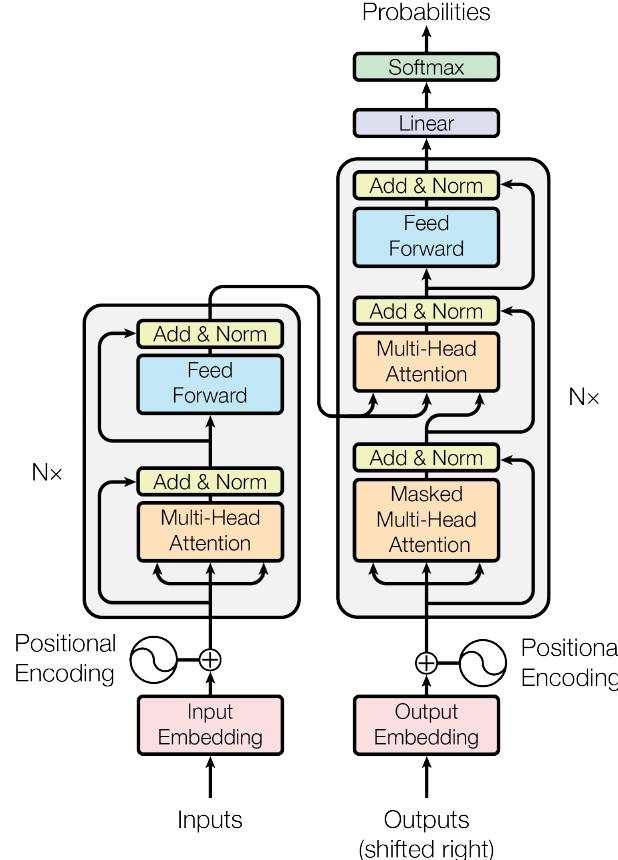

In [40]:
response = chain_with_sources.invoke(
    "What is the transformer architecture?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

# Podcast  with PDF
Create a Podcast of the PDF Summary with Specific Questions asked by RAG

### Prequsite Step 

 Include any specific question as questions from the auidence 

In [41]:
def specific_question_from_audience(l):
     
    response_outputs = ""

    for i in l:
        response = chain_with_sources.invoke(
            i
        )

        final_output_response = f"{response['response']} + "

        text = ""
        for r in response['context']['texts']:
            text = text + str(r)

        final_output_response = f"{response['response']}\n\nContext\n\n{text}" 

        response_outputs = response_outputs + f"Question:\n{i}\n\n" + f"Output from relevant chunks of the PDF:\n{final_output_response}"

    return response_outputs


In [72]:
specific_question_from_audience(["What is Positional Encoding?"])

'Question:\nWhat is Positional Encoding?\n\nOutput from relevant chunks of the PDF:\nPositional Encoding is a method used in transformer models to encode the position of each token in a sequence since the model lacks inherent knowledge of the order of the tokens. It adds information about the relative or absolute position of tokens to the input embeddings. In this case, sine and cosine functions of varying frequencies are used, allowing the model to learn to pay attention to the relative positions effectively.\n\nThe positional encodings have the same dimension as the embeddings, enabling them to be summed. This method enables the model to generalize to longer sequences than those it was trained on, allowing it to better handle sequence order in tasks involving language and other sequential data.\n\nContext\n\n3.3 Position-wise Feed-Forward Networks\n\nIn addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, whi

### Step 1: Create a podcast_transcript

In [73]:
example_transcript = """Example Podcast Transcript: 
<Person1> "Hello listeners, and welcome to SID's Podcast - Your Personal Generative AI Podcast. Today, we're diving into a hot topic: Elon Musk and the fall of Tesla! Buckle up for a dynamic debate."
</Person1><Person2> "Absolutely! We're here to break down the factors behind Tesla's recent struggles and what role, if any, Elon Musk's decisions have played. Let's get into it!"
</Person2><Person1> "Right on! On one hand, there's a strong argument that attributes Tesla's challenges to Musk's controversial decisions and unpredictable public behavior. Critics suggest that these factors have shaken investor confidence and contributed to market volatility."
</Person1><Person2> "On the other hand, some say that Tesla's current hurdles are simply part of the natural business cycle—impacted by market competition, supply chain disruptions, and evolving consumer trends. They believe Musk's bold, innovative vision continues to drive the company forward."
</Person2><Person1> "Exactly. So the burning question is: Are Tesla's setbacks really the result of Musk's actions, or are they just a temporary phase in the journey of a pioneering tech company?"
</Person1><Person2> "Some point out that his high-profile social media antics and risky business maneuvers have created distractions, leading to an unstable market reaction. They argue that these issues highlight deeper problems in corporate governance."
</Person2><Person1> "Yet others counter that disruptive innovation is never a smooth ride. Musk's daring approach has propelled Tesla to unprecedented heights before, and current challenges might simply be a growing pain rather than a sign of irreversible decline."
</Person1><Person2> "Indeed. It really raises questions about leadership and accountability in high-stakes tech ventures. Can a visionary leader navigate such turbulence without compromising the company's mission?"
</Person2><Person1> "That's the million-dollar question. Whether you view it as a fall from grace or just a strategic pause, this discussion challenges us to reconsider the complex relationship between a leader's personality, corporate strategy, and market dynamics."
</Person1><Person2> "Well said! It's a multifaceted issue that goes beyond assigning blame, reminding us that in the world of disruptive technology, highs and lows are part of the journey."
</Person2><Person1> "Absolutely. That wraps up today's deep dive into Elon Musk and the challenges Tesla faces. Thanks for joining us on SID's Podcast. Until next time, stay curious and keep exploring!"
</Person1><Person2> "Catch you all on the next episode!"
</Person2>"""

text_summary = "Text Summaries:\n" + "\n".join(text_summaries)
table_summary = "Table Summaries:\n" + "\n".join(table_summaries)
image_summary = "Image Summaries:\n" + "\n".join(image_summaries)

In [74]:
template = """You are an assistant in TV channel tasked with creating a podcast transcript for two Hosts, hosting a podcast named SID's Podcast. Your task is to use Text Summaries, Table Summaries, Images Summaries and Specific Questions (From Audience) with context from a pdf to create a transcript similar to the given transcript (include html tags) in the output.

{text_summaries}

{table_summaries}

{image_summaries}

Add specific questions as given below by audience at the end of the podcast before wrapping up in a QA session stating something like : 'Now lets us address some questions from our Audiences
{specific_questions}

{example_transcript}

Wrap up saying something along the line of. Thanks for tuning in. We look forward to seeing you in the next epsisode.
"""

podcast_prompt_template = PromptTemplate(template=template, input_variables=["text_summaries", "table_summaries", "image_summaries", "specific_questions", "example_transcript"])
formatted_prompt = podcast_prompt_template.format(text_summaries=text_summary, 
                                 table_summaries=table_summary, 
                                 image_summaries=image_summary,
                                 specific_questions=specific_question_from_audience(["What is Positional Encoding", "What is Attention Mechanism Formula"]),
                                 example_transcript=example_transcript)

print(formatted_prompt)  # Output: Translate the following text to French: Hello, world!

You are an assistant in TV channel tasked with creating a podcast transcript for two Hosts, hosting a podcast named SID's Podcast. Your task is to use Text Summaries, Table Summaries, Images Summaries and Specific Questions (From Audience) with context from a pdf to create a transcript similar to the given transcript (include html tags) in the output.

Text Summaries:
The paper introduces the Transformer, a new architecture for sequence transduction based solely on attention mechanisms, eliminating the need for recurrent or convolutional neural networks. The Transformer outperforms existing models in machine translation tasks, achieving a BLEU score of 28.4 for English-to-German and 41.8 for English-to-French, significantly reducing training time and costs. The contributions of multiple authors from Google Brain and Google Research are acknowledged, highlighting their roles in developing and implementing the model and its variants. The Transformer also exhibits strong generalization to

In [75]:
model = init_chat_model("gpt-4o", model_provider="openai")
response = model.invoke(formatted_prompt)

In [76]:
with open("data/transcripts/transcript.txt", "w") as file:
    file.write(response.content)

In [77]:
def embed_audio(audio_file):
	"""
	Embeds an audio file in the notebook, making it playable.

	Args:
		audio_file (str): Path to the audio file.
	"""
	try:
		display(Audio(audio_file))
		print(f"Audio player embedded for: {audio_file}")
	except Exception as e:
		print(f"Error embedding audio: {str(e)}")

In [78]:
audio_file = generate_podcast(transcript_file='data/transcripts/transcript.txt',
                              tts_model="edge",
                              llm_model_name="gpt-4o",
                              api_key_label="OPENAI_API_KEY")

2025-05-16 04:26:50,405 - podcastfy.client - INFO - Using transcript file: data/transcripts/transcript.txt


Generating podcast...


2025-05-16 04:27:06,767 - podcastfy.client - INFO - Podcast generated successfully using edge TTS model
